<h1 style="text-align:center;font-size:36px">IMPORT DES DONNEES DE TRAFIC, BRUIT, METEO ET SONDAGE</h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(r'C:\Users\martin.schoreisz\git\otv\otv\Transfert_Donnees')
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\src')
sys.path.append(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\donnees_produites\Codes\src\Carac_situ_acoustiq')
sys.path.append(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\donnees_produites\Codes\src')

import os, re
import pandas as pd
import numpy as np
import altair as alt
from math import pi, log, cos, sqrt, radians, degrees
from datetime import timedelta, datetime, time
from IPython.display import Image
from Import_stockage_donnees.Import_export_bdd import FichierMesureBruitCsv, FichierCsvEnquete, ResultatsEnquete, FichiersMeteo
from Import_stockage_donnees.Params import (bdd, attributMesureTrafic, listFichiers6Min, fichierHoraireS43, dicoSiteLibCanal, dossierTrafic,
                                            fichierHoraireS44S45, dicoLibCanalVoie, dicoLibCanalSens, listNatureMesure)
from Connexions import Connexion_Transfert as ct
from Bruit.Niveaux import niveau2Pression, pression2Niveau, moyenneQuadratiquePression
from Bruit.Meteo import *
from statistics import mean, harmonic_mean
from Import_trafics import Comptage_Dira

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
# alt.data_transformers.disable_max_rows()
# alt.data_transformers.enable('json')

# DONNEES BRUIT

> ## Lecture des fichiers ods

In [36]:
# exemple de lecture 
test = FichierMesureBruitCsv(r'C:\Users\martin.schoreisz\Documents\temp\BruitRessenti\mesures\CSV\sono1_10RuePierreRonsard\sono1_02-04-2022.csv')
# test.dfNiveauSpectre.head(10)

In [ ]:
# transfert vers Bdd par dossier
dossierSrc = r'C:\Users\martin.schoreisz\Documents\temp\BruitRessenti\mesures\CSV\sono4_26RueFrancoisVillon'
transfertFichierMesure2Bdd(dossierSrc)

# DONNEES RESSENTI

## Import des données brutes  
Il s'agit de lire le fichier, de le nettoyer puis de le rendre plus compréhensible.  
Comme le fichier mélange des données fournies par les riverains directement par LimeSurvey et d'autre issus du transfert depuis des questionnaires papiers, il faut également s'assurer de la présence d'un identifiant unique par riverains, en créant des adresses mail factice pour les réoponses issues de questionaire papier.

In [87]:
ressenti = FichierCsvEnquete(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\Enquete_LimeSurvey\resultats_LimeSurvey_Bruts\resultats_complets_enquete_avec_papier.csv')
# cf les attributs pour consulter les données si besoin

# DONNEES MÉTÉO
L'objectif est double : 
1. fournir des rose des vents selon une période de temps définie
1. fournir le statut de propagation acoustique (favorable / défavorable) selon l'angle et une période de temps définie

## Import des données brutes  
Les données sont réparties sur 2 fichiers dans le dossier suivant C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\station_meteo\datas  
On en profite pour jeter un oeil aux données fournie par les girouette

In [3]:
fichierMeteo = FichiersMeteo(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\station_meteo\datas',
                             ['Mesures_Ech24_21-03-2022_04-04-2022.csv', 'Mesures_Ech24_04-04-2022_19-04-2022.csv'])

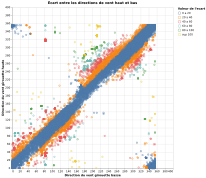

In [14]:
# preparation des données de comparaison des girouettes
dfDirVentComp = fichierMeteo.analyseDirVents(fichierMeteo.dfBrutes)
# si besoin : fichierMeteo.graphDiffDirVent(dfDirVentComp, fichier_de_sauvegarde)
# visu des résultats
Image('images/ecart_dirVent_HautBas.png', width=600, height=600)

**Dans tous les cas les données à conserver sont celles de la girouette haute. Cependant, on peut noter que les différences supérieures à 40° sont marginales**

## Import des données MétéoFrance
Les données sont issue du site de MeteoFrance openData https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32

In [4]:
dossier = r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\donnees_sources\MeteoFrance'
fichiersMesures = ['synop.202203.csv',  'synop.202204.csv']
dfMeteoFranceAll = pd.concat([pd.read_csv(os.path.join(dossier, f),
                                          sep=';',
                                          na_values='mq',
                                          usecols=listeColonnesMeteoFrance,
                                          parse_dates=[1]) for f in fichiersMesures]).rename(columns=dicoColonneMeteoFrance)
dfMeteoFranceBx = dfMeteoFranceAll.loc[dfMeteoFranceAll.station == numStationMerignac].copy()

In [29]:
with ct.ConnexionBdd(bdd) as c:
    dfMeteoFranceBx.to_sql('meteo_france', c.sqlAlchemyConn, schema='mesures_physiques')

# DONNÉES TRAFIC
Il y a de la donnée sur la Rocade, l'avenue dubedout et l'ex-RD936 
dans tous les cas, il est possible de sortir de la donnée 6 minutes

## Rocade
les fichiers sont :
- 6 minutes en débit / vitesses pour les sections courantes
- 6 minutes en debit pour les bretelles
- horaire pour le %PL sur section courante
Dans certains fichier il y a la section courante complete, plus les décomposition en voie je pense. ça se trouve dans les 'lib_Canal', en XXXX.00 pour la section courante dans un sens ou en XXXX.91 ou 93 ou 95 et XXXX.90 ou 92 ou 94. La relation avec la réalité est assuré par les fichiers horaires et les données OTV.<br>

Il faut également filtrer certaines données 6 minutes entre 02h00 et 03h00, sur les 3 compteurs, car aucunes données n'est remontée.<br>

In [125]:
# ouverture et filtre des données
df6Min = pd.concat([pd.read_excel(f) for f in listFichiers6Min])
df6MinFiltre = df6Min.loc[df6Min['Lib Canal'].isin(dicoLibCanalVoie.keys()) & (df6Min['nature de mesure'].isin(listNatureMesure))] .copy()

In [ ]:
# traitement des données 6 minutes
df6MinFiltre['date_heure'] = df6MinFiltre.apply(lambda x: pd.to_datetime(f'{x.jour} {x.sequence}') + pd.to_timedelta('1 s'), axis=1)
df6MinFiltre.loc[df6MinFiltre['nature de mesure'] == 'Débit', 'indicateur'] = 'TV'
df6MinFiltre.loc[df6MinFiltre['nature de mesure'] == 'Vitesse', 'indicateur'] = 'Vmoy'
df6MinFiltre['id_instru_site'] = df6MinFiltre['Lib Canal'].apply(lambda x: [k for k, v in dicoSiteLibCanal.items() if x in v][0])
df6MinFiltre['voie'] = df6MinFiltre['Lib Canal'].apply(lambda x: dicoLibCanalVoie[x])
df6MinFiltre['sens'] = df6MinFiltre['Lib Canal'].apply(lambda x: dicoLibCanalSens[x])
df6MinFiltre['periode_agreg'] = '6 min'
df6MinFiltre.rename(columns={'mesure': 'valeur'}, inplace = True)
df6MinFinal = df6MinFiltre.loc[df6MinFiltre.valeur.notna()].drop([c for c in df6MinFiltre.columns if c not in attributMesureTrafic], axis=1)

In [46]:
# traiatements des données horaires
dira = Comptage_Dira('toto', dossierTrafic, 'tutu', 2022, 'compteur')
dfHoraireBrute = pd.concat([dira.miseEnFormeFichier(fichierHoraireS43, nbJoursValideMin=1, FlagHorsOTV=True, nbHeure0Max=24).assign(id_instru_site=7),
                            dira.miseEnFormeFichier(fichierHoraireS44S45, nbJoursValideMin=1, FlagHorsOTV=True, nbHeure0Max=24).assign(id_instru_site=8)])
dfHoraire = dfHoraireBrute.melt(
    id_vars=['jour', 'type_veh', 'id_dira', 'voie', 'id_instru_site'],
    value_vars=[c for c in dfHoraireBrute.columns if c[0] == 'h'],
    value_name='valeur', var_name='heure').rename(columns={'type_veh': 'indicateur', 'voie': 'voie_init'})
dfHoraire['date_heure'] = dfHoraire.apply(lambda x: pd.to_datetime(f"{x.jour.date()} {x.heure.split('_')[0].replace('h','').rjust(2, '0')}:00:00"), axis=1)
dfHoraire['sens'] = dfHoraire.voie_init.apply(lambda x: ' '.join(x.split(' ')[:2]).lower())
dfHoraire['voie'] = dfHoraire.voie_init.apply(lambda x: ' '.join(x.split(' ')[2:]).lower() if len(x.split(' ')) > 2 else 'section courante')
dfHoraire['periode_agreg'] = '1 h'
dfHoraireFinal = dfHoraire.drop([c for c in dfHoraire.columns if c not in attributMesureTrafic], axis=1)

S_MB333.M_0
S_MB333.M_1
S_MB333.M_2
S_MB333.M_3
S_MB333.M_4
S_MB333.M_5
S_MB333.M_6
S_MB333.M_7
S_MBG33.N_0
S_MBG33.N_1


In [ ]:
# transfert en bdd
with ct.ConnexionBdd(bdd) as c:
    dfHoraireFinal.to_sql('trafic', c.sqlAlchemyConn, schema='mesures_physiques', if_exists='append', index=False)

## Ex-D936
les fichiers sont :
- produit par le Cerema
- produit par un presta pour Bordeaux Métropole
Ce sont dans les deux cas des fichiers au véhicules, que l'on va agréger en donnée 6 minutes

### CPEV du 04 avril au 19 avril

In [3]:
# lecture des données individuelles tout sens confondus
fichierVersBordeauxSemaine1 = r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\trafic\exD936\du_04-04-2022 au 18-04-2022_CEPV\CSV\Semaine1\Vers_Bordeaux\00030093-20220331123748.CSV'
fichierVersBordeauxSemaine2 = r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\trafic\exD936\du_04-04-2022 au 18-04-2022_CEPV\CSV\Semaine2\Vers_Bordeaux\00030095-20220407104915.CSV'
fichierVersRocadeSemaine1 = r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\trafic\exD936\du_04-04-2022 au 18-04-2022_CEPV\CSV\Semaine1\Vers_Rocade\00000033-20220331122920.CSV'
fichierVersRocadeSemaine2 = r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\trafic\exD936\du_04-04-2022 au 18-04-2022_CEPV\CSV\Semaine2\Vers_Rocade\00000119-20220407104120.csv'
dfBm = pd.concat([pd.read_csv(e, names=['date', 'heure', 'vitesse', 'longueur', 'div', 'voie', 'reverse'], skiprows=5).assign(sens=k) 
 for k, v in {'vers bordeaux': [fichierVersBordeauxSemaine1, fichierVersBordeauxSemaine2],
              'vers libourne': [fichierVersRocadeSemaine1, fichierVersRocadeSemaine2]}.items() 
 for e in v])
dfBm['date_heure'] = pd.to_datetime(dfBm.date + ' ' + dfBm.heure, dayfirst=True)
dfBm['indicateur'] = dfBm.longueur.apply(lambda x: 'VL' if x <= 6 else 'PL')

In [4]:
# regroupement en 6 minutes pour coller aux données DIR
dfBm6min = dfBm.groupby([pd.Grouper(freq='6min', key='date_heure'), 'indicateur', 'sens']).agg({'date': 'count', 'vitesse': lambda x: harmonic_mean(list(x))}).reset_index().rename(
    columns={'date': 'valeur'}).sort_values(['sens', 'date_heure', 'indicateur'])

In [5]:
# formatage pour insertion dans Bdd
df6minFormatBdd = pd.concat([dfBm6min.loc[dfBm6min.indicateur.isin(('VL', 'PL'))][['date_heure', 'indicateur', 'valeur', 'sens']],
                             dfBm6min.drop('valeur', axis=1).loc[dfBm6min.indicateur == 'VL'].rename(
                                 columns={'vitesse': 'Vmoy_VL'}).melt(
                                 id_vars=['date_heure', 'sens'], value_vars='Vmoy_VL', value_name='valeur', var_name='indicateur'),
                             dfBm6min.drop('valeur', axis=1).loc[dfBm6min.indicateur == 'PL'].rename(
                                 columns={'vitesse': 'Vmoy_PL'}).melt(
                                 id_vars=['date_heure', 'sens'], value_vars='Vmoy_PL', value_name='valeur', var_name='indicateur')]
                           ).assign(id_instru_site=6,
                                    periode_agreg='6 min',
                                    voie='section courante')

In [59]:
# transfert en bdd
with ct.ConnexionBdd(bdd) as c:
    df6minFormatBdd.to_sql('trafic', c.sqlAlchemyConn, schema='mesures_physiques', if_exists='append', index=False)

In [8]:
# estimation
# lecture du fichier creer
dfEstim = pd.read_json(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\trafic\exD936\estimation_Q_V\estimationDebitsVitesse.json')

In [55]:
# création d'un index de temps par 30 minutes avec champs de jointure vers le fichier d'estim
dfEstimTot = pd.DataFrame(pd.date_range('2022-03-21', '2022-03-31 12:30:00', freq='30min'), columns=['date_heure'])
dfEstimTot['temp'] = dfEstimTot.date_heure.dt.strftime('%H:%M:%S')
# jointure avec le fichier d'estim
dfEstimNan = (pd.concat([dfEstimTot.loc[dfEstimTot.date_heure.dt.dayofweek.isin(range(5))].merge(dfEstim.loc[dfEstim.type_jour == 'ouvre'], on='temp', how='left'),
                        dfEstimTot.loc[dfEstimTot.date_heure.dt.dayofweek == 5].merge(dfEstim.loc[dfEstim.type_jour == 'samedi'], on='temp', how='left'),
                        dfEstimTot.loc[dfEstimTot.date_heure.dt.dayofweek == 6].merge(dfEstim.loc[dfEstim.type_jour == 'dimanche'], on='temp', how='left')])
 .set_index('date_heure')
 .resample('6min').asfreq())
# creation de la df des debits, par sens
dfEstimDebits = pd.concat([dfEstimNan[i].apply(lambda x: x/(5*2)).ffill().reset_index().assign(indicateur=i.upper(), sens=s).rename(columns={i: 'valeur'})
                           for i, s in (('vl', 'vers bordeaux'), ('vl', 'vers libourne'), ('pl', 'vers bordeaux'), ('pl', 'vers libourne'))])
# creation de la df des vitesses, par sens
dfEstimVitesse = pd.concat([dfEstimNan[['vts_pl', 'vts_vl']].ffill().rename(columns={'vts_pl': 'Vmoy_PL', 'vts_vl': 'Vmoy_VL'}).stack().reset_index(
    ).rename(columns={'level_1': 'indicateur', 0: 'valeur'}).assign(sens=s) for s in ('vers bordeaux', 'vers libourne')])
# creation de la df totale
dfEstimTrafic = pd.concat([dfEstimDebits, dfEstimVitesse]).assign(voie="section courante",
                                                                  id_instru_site=6,
                                                                  comm="débit et vitesse estimés par moyenne arithmétique et harmonique",
                                                                  periode_agreg='6 min'
                                                                 ).reset_index(drop=True)

In [60]:
# export des données pour save
dfEstimTrafic.to_json(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\trafic\exD936\estimation_Q_V\estimationDebitsVitesseFormatBdd.json')

In [61]:
with ct.ConnexionBdd(bdd) as c:
    dfEstimTrafic.to_sql('trafic', c.sqlAlchemyConn, schema='mesures_physiques', if_exists='append', index=False)

In [40]:
dfEstimTrafic.sort_values('date_heure').tail(10)

date_heure     valeur indicateur           sens  \
2524  2022-03-31 12:24:00  87.000000         VL  vers bordeaux   
7576  2022-03-31 12:24:00   7.100000         PL  vers bordeaux   
10103 2022-03-31 12:30:00   5.300000         PL  vers libourne   
15154 2022-03-31 12:30:00  55.788517    Vmoy_PL  vers bordeaux   
20206 2022-03-31 12:30:00  55.788517    Vmoy_PL  vers libourne   
7577  2022-03-31 12:30:00   5.300000         PL  vers bordeaux   
5051  2022-03-31 12:30:00  73.900000         VL  vers libourne   
2525  2022-03-31 12:30:00  73.900000         VL  vers bordeaux   
15155 2022-03-31 12:30:00  56.439139    Vmoy_VL  vers bordeaux   
20207 2022-03-31 12:30:00  56.439139    Vmoy_VL  vers libourne   

                   voie  id_instru_site  \
2524   section courante               6   
7576   section courante               6   
10103  section courante               6   
15154  section courante               6   
20206  section courante               6   
7577   section courante               6   
5051   section courante               6   
2525   section courante               6   
15155  section courante               6   
20207  section courante               6   

                                                                  comm  \
2524   débit et vitesse estimés par moyenne arithmétique et harmonique   
7576   débit et vitesse estimés par moyenne arithmétique et harmonique   
10103  débit et vitesse estimés par moyenne arithmétique et harmonique   
15154  débit et vitesse estimés par moyenne arithmétique et harmonique   
20206  débit et vitesse estimés par moyenne arithmétique et harmonique   
7577   débit et vitesse estimés par moyenne arithmétique et harmonique   
5051   débit et vitesse estimés par moyenne arithmétique et harmonique   
2525   débit et vitesse estimés par moyenne arithmétique et harmonique   
15155  débit et vitesse estimés par moyenne arithmétique et harmonique   
20207  débit et vitesse estimés par moyenne arithmétique et harmonique   

      periode_agreg  
2524          6 min  
7576          6 min  
10103         6 min  
15154         6 min  
20206         6 min  
7577          6 min  
5051          6 min  
2525          6 min  
15155         6 min  
20207         6 min

In [59]:
dfEstimTrafic.loc[dfEstimTrafic.date_heure.dt.dayofweek == 5].head(10)

date_heure     valeur indicateur           sens  \
1200 2022-03-26 00:00:00  24.433333         VL  vers bordeaux   
1201 2022-03-26 00:06:00  24.433333         VL  vers bordeaux   
1202 2022-03-26 00:12:00  24.433333         VL  vers bordeaux   
1203 2022-03-26 00:18:00  24.433333         VL  vers bordeaux   
1204 2022-03-26 00:24:00  24.433333         VL  vers bordeaux   
1205 2022-03-26 00:30:00  19.633333         VL  vers bordeaux   
1206 2022-03-26 00:36:00  19.633333         VL  vers bordeaux   
1207 2022-03-26 00:42:00  19.633333         VL  vers bordeaux   
1208 2022-03-26 00:48:00  19.633333         VL  vers bordeaux   
1209 2022-03-26 00:54:00  19.633333         VL  vers bordeaux   

                  voie  id_instru_site  \
1200  section courante               6   
1201  section courante               6   
1202  section courante               6   
1203  section courante               6   
1204  section courante               6   
1205  section courante               6   
1206  section courante               6   
1207  section courante               6   
1208  section courante               6   
1209  section courante               6   

                                                                 comm  \
1200  débit et vitesse estimés par moyenne arithmétique et harmonique   
1201  débit et vitesse estimés par moyenne arithmétique et harmonique   
1202  débit et vitesse estimés par moyenne arithmétique et harmonique   
1203  débit et vitesse estimés par moyenne arithmétique et harmonique   
1204  débit et vitesse estimés par moyenne arithmétique et harmonique   
1205  débit et vitesse estimés par moyenne arithmétique et harmonique   
1206  débit et vitesse estimés par moyenne arithmétique et harmonique   
1207  débit et vitesse estimés par moyenne arithmétique et harmonique   
1208  débit et vitesse estimés par moyenne arithmétique et harmonique   
1209  débit et vitesse estimés par moyenne arithmétique et harmonique   

     periode_agreg  
1200         6 min  
1201         6 min  
1202         6 min  
1203         6 min  
1204         6 min  
1205         6 min  
1206         6 min  
1207         6 min  
1208         6 min  
1209         6 min

In [48]:
dfEstimNan

temp type_jour    pl     vl     vts_pl     vts_vl
date_heure                                                                
2022-03-21 00:00:00  00:00:00     ouvre   3.0  110.0  56.477756  61.639071
2022-03-21 00:06:00       NaN       NaN   NaN    NaN        NaN        NaN
2022-03-21 00:12:00       NaN       NaN   NaN    NaN        NaN        NaN
2022-03-21 00:18:00       NaN       NaN   NaN    NaN        NaN        NaN
2022-03-21 00:24:00       NaN       NaN   NaN    NaN        NaN        NaN
...                       ...       ...   ...    ...        ...        ...
2022-03-31 12:06:00       NaN       NaN   NaN    NaN        NaN        NaN
2022-03-31 12:12:00       NaN       NaN   NaN    NaN        NaN        NaN
2022-03-31 12:18:00       NaN       NaN   NaN    NaN        NaN        NaN
2022-03-31 12:24:00       NaN       NaN   NaN    NaN        NaN        NaN
2022-03-31 12:30:00  12:30:00     ouvre  53.0  739.0  55.788517  56.439139

[2526 rows x 6 columns]